In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')

# 机器学习模型
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 预处理和评估
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 加载数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"训练集形状: {train.shape}")
print(f"测试集形状: {test.shape}")

# 保存ID列
train_ID = train['Id']
test_ID = test['Id']

# 删除ID列
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

print(f"删除ID后的训练集形状: {train.shape}")
print(f"删除ID后的测试集形状: {test.shape}")

训练集形状: (1460, 81)
测试集形状: (1459, 80)
删除ID后的训练集形状: (1460, 80)
删除ID后的测试集形状: (1459, 79)


# 1. 探索性数据分析

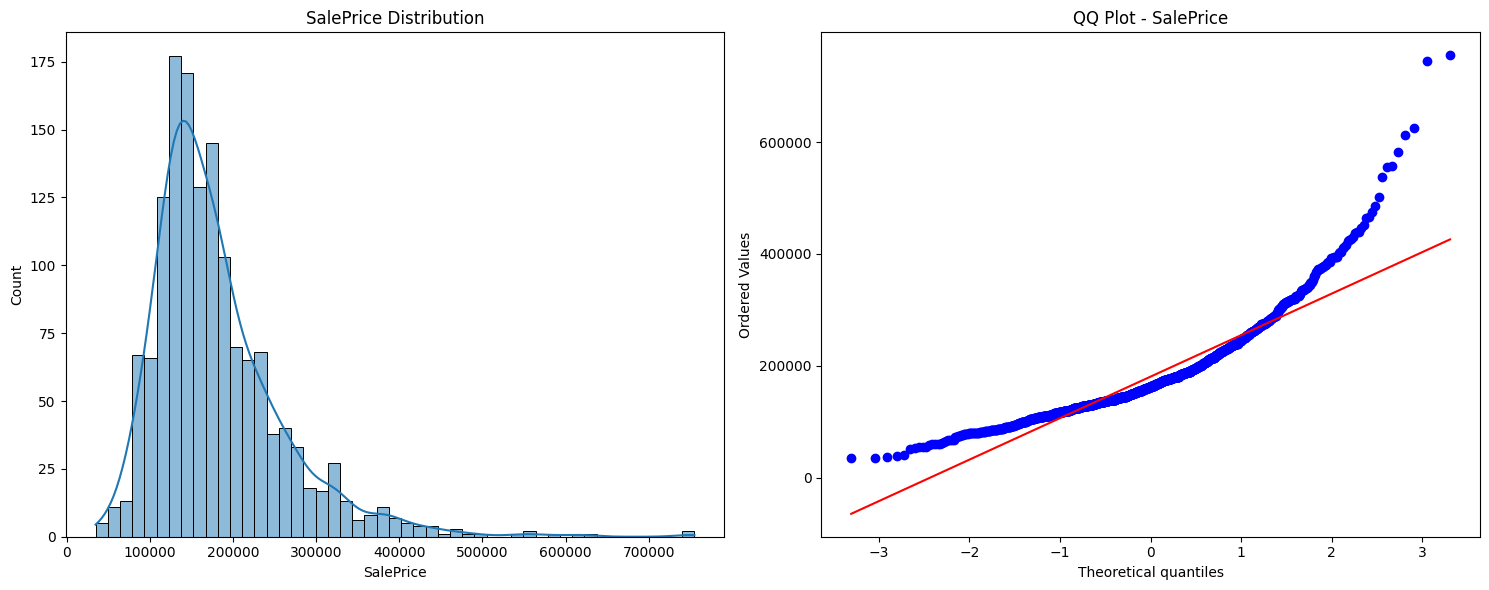

SalePrice 偏度: 1.8829
SalePrice 峰度: 6.5363


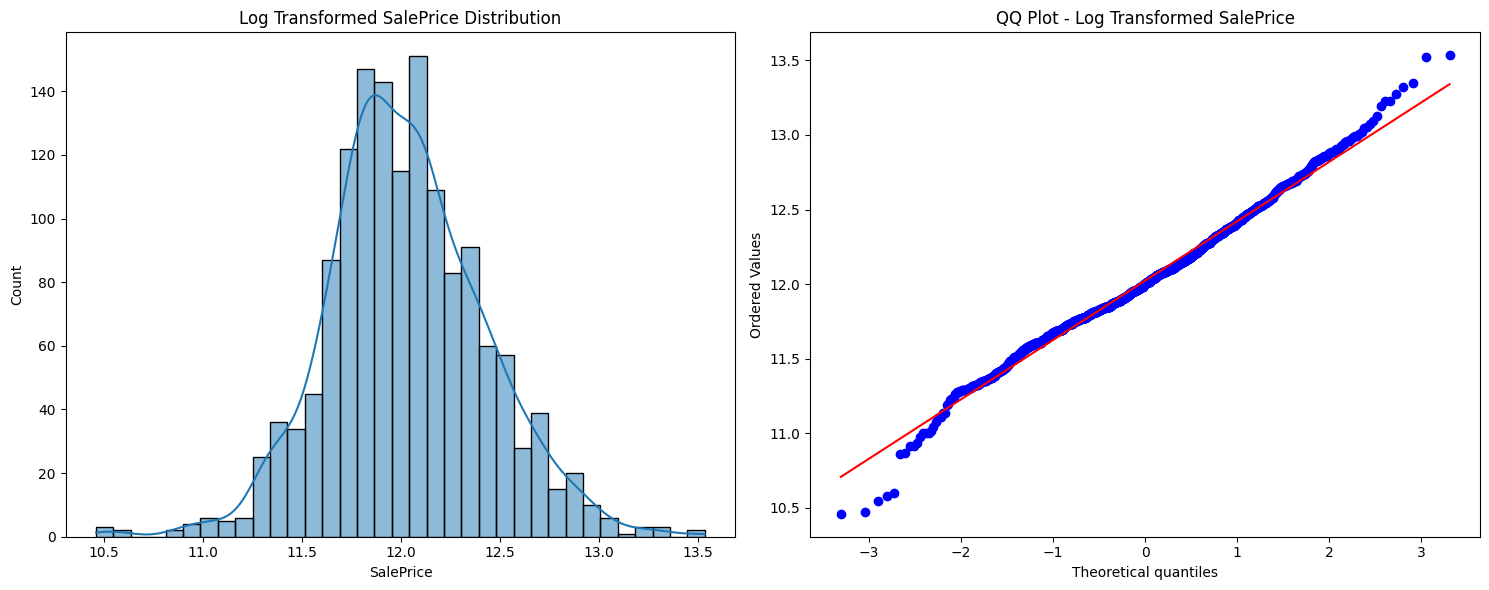

In [3]:
# 目标变量分析
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 分布图
sns.histplot(train['SalePrice'], kde=True, ax=axes[0])
axes[0].set_title('SalePrice Distribution')

# QQ图
stats.probplot(train['SalePrice'], plot=axes[1])
axes[1].set_title('QQ Plot - SalePrice')

plt.tight_layout()
plt.show()

print(f"SalePrice 偏度: {train['SalePrice'].skew():.4f}")
print(f"SalePrice 峰度: {train['SalePrice'].kurt():.4f}")

# 对目标变量进行对数变换以减少偏度
train["SalePrice"] = np.log1p(train["SalePrice"])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(train['SalePrice'], kde=True, ax=axes[0])
axes[0].set_title('Log Transformed SalePrice Distribution')

stats.probplot(train['SalePrice'], plot=axes[1])
axes[1].set_title('QQ Plot - Log Transformed SalePrice')
plt.tight_layout()
plt.show()

2. 数据预处理和特征工程

In [4]:
# 合并训练集和测试集进行统一预处理
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print(f"合并后数据形状: {all_data.shape}")

# 处理缺失值
def handle_missing_values(df):
    # 按照data_description.txt的说明处理缺失值
    df = df.copy()
    
    # 这些特征的NA表示"无"
    none_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                   'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                   'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                   'MasVnrType']
    
    for feature in none_features:
        df[feature] = df[feature].fillna('None')
    
    # 这些特征的NA表示0
    zero_features = ['MasVnrArea', 'GarageYrBlt', 'GarageArea', 'GarageCars',
                   'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                   'BsmtFullBath', 'BsmtHalfBath']
    
    for feature in zero_features:
        df[feature] = df[feature].fillna(0)
    
    # 其他特殊处理
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median()))
    
    # 用众数填充分类变量
    categorical_features = df.select_dtypes(include=['object']).columns
    for feature in categorical_features:
        df[feature] = df[feature].fillna(df[feature].mode()[0])
    
    # 用中位数填充数值变量
    numerical_features = df.select_dtypes(include=[np.number]).columns
    for feature in numerical_features:
        df[feature] = df[feature].fillna(df[feature].median())
    
    return df

all_data = handle_missing_values(all_data)

# 检查是否还有缺失值
missing = all_data.isnull().sum()
missing = missing[missing > 0]
print(f"剩余缺失值数量: {len(missing)}")

合并后数据形状: (2919, 79)
剩余缺失值数量: 0


# 3. 高级特征工程

In [5]:
def create_new_features(df):
    df = df.copy()
    
    # 总面积特征
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
    df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    
    # 房屋年龄相关特征
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['IsNew'] = (df['YearBuilt'] == df['YrSold']).astype(int)
    
    # 质量相关组合特征
    df['OverallQual_TotalSF'] = df['OverallQual'] * df['TotalSF']
    df['OverallQual_GrLivArea'] = df['OverallQual'] * df['GrLivArea']
    df['OverallQual_YearBuilt'] = df['OverallQual'] * df['YearBuilt']
    
    # 其他重要特征组合
    df['KitchenQual_GrLivArea'] = df['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}) * df['GrLivArea']
    df['GarageCars_GarageArea'] = df['GarageCars'] * df['GarageArea']
    
    # 简化分类变量
    df['SimplOverallQual'] = df['OverallQual'].replace({1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 
                                                       6: 3, 7: 3, 8: 4, 9: 4, 10: 5})
    df['SimplOverallCond'] = df['OverallCond'].replace({1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 
                                                       6: 3, 7: 3, 8: 4, 9: 4, 10: 5})
    
    return df

all_data = create_new_features(all_data)

# 处理偏斜的数值特征
numeric_feats = all_data.select_dtypes(include=[np.number]).columns

# 检查数值特征的偏度
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness = skewness[abs(skewness) > 0.75]
print(f"需要处理偏度的特征数量: {len(skewness)}")

from scipy.special import boxcox1p

# 对偏斜特征进行Box-Cox变换
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

需要处理偏度的特征数量: 49


# 4. 编码分类变量

In [6]:
# 对分类变量进行标签编码
categorical_features = all_data.select_dtypes(include=['object']).columns
print(f"分类变量数量: {len(categorical_features)}")

# 对有序分类变量进行映射
quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
exposure_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
finish_map = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
function_map = {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0}

quality_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                  'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

for feature in quality_features:
    all_data[feature] = all_data[feature].map(quality_map).fillna(0)

all_data['BsmtExposure'] = all_data['BsmtExposure'].map(exposure_map).fillna(0)
all_data['GarageFinish'] = all_data['GarageFinish'].map(finish_map).fillna(0)
all_data['Functional'] = all_data['Functional'].map(function_map).fillna(7)

# 对其他分类变量进行one-hot编码
all_data = pd.get_dummies(all_data)

print(f"特征工程后的数据形状: {all_data.shape}")

分类变量数量: 43
特征工程后的数据形状: (2919, 262)


# 5. 准备训练和测试数据

In [7]:
# 分割回训练集和测试集
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]

# 删除异常值（基于EDA发现的重要异常点）
outliers = [30, 88, 462, 631, 1322]  # 这些是在GrLivArea和SalePrice散点图中明显的异常值
X_train = X_train.drop(X_train.index[outliers])
y_train = np.delete(y_train, outliers)

print(f"处理异常值后的训练集形状: {X_train.shape}")

处理异常值后的训练集形状: (1455, 262)


# 6. 模型构建和集成

In [8]:
# 定义交叉验证策略
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 定义模型
models = {
    'lasso': make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=42, max_iter=10000)),
    'ridge': make_pipeline(RobustScaler(), Ridge(alpha=13, random_state=42)),
    'elasticnet': make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42, max_iter=10000)),
    'kernel_ridge': make_pipeline(RobustScaler(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)),
    'gradient_boost': GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, 
                                            max_features='sqrt', min_samples_leaf=15, 
                                            min_samples_split=10, loss='huber', random_state=42),
    'xgboost': XGBRegressor(n_estimators=2000, learning_rate=0.05, max_depth=3, 
                          subsample=0.8, colsample_bytree=0.8, random_state=42),
    'lightgbm': LGBMRegressor(n_estimators=2000, learning_rate=0.05, max_depth=3, 
                            subsample=0.8, colsample_bytree=0.8, random_state=42)
}

# 评估单个模型
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

model_scores = {}
for name, model in models.items():
    score = rmse_cv(model, X_train, y_train)
    model_scores[name] = score
    print(f"{name:15} : {score.mean():.6f} (+/- {score.std():.6f})")

lasso           : 0.117901 (+/- 0.036929)
ridge           : 0.120697 (+/- 0.038344)
elasticnet      : 0.117897 (+/- 0.036855)
kernel_ridge    : 0.130891 (+/- 0.044569)
gradient_boost  : 0.118091 (+/- 0.035783)
xgboost         : 0.119242 (+/- 0.034017)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5222
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 178
[LightGBM] [Info] Start training from score 12.026078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

# 7. 模型集成

In [13]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
class AveragingModels(BaseEstimator, RegressorMixin):
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights
        if self.weights is None:
            self.weights = [1/len(models)] * len(models)
    
    def fit(self, X, y):
        # 创建模型的深拷贝，避免修改原始模型
        self.models_ = [clone(model) for model in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.average(predictions, axis=1, weights=self.weights)
    
    def get_params(self, deep=True):
        # 这个方法让模型可以被克隆
        return {'models': self.models, 'weights': self.weights}

# 修正模型名称的拼写错误
best_models = [
    models['lasso'],  
    models['ridge'], 
    models['gradient_boost'],  
    models['xgboost'],  
    models['lightgbm']  
]

weights = [0.15, 0.15, 0.25, 0.25, 0.2]

averaged_models = AveragingModels(best_models, weights=weights)

# 评估集成模型
ensemble_score = rmse_cv(averaged_models, X_train, y_train)  # 修正变量名
print(f"集成模型: {ensemble_score.mean():.6f} (+/- {ensemble_score.std():.6f})")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 178
[LightGBM] [Info] Start training from score 12.026078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

# 8. 最终模型训练和预测

In [ ]:
# 检查测试集中的缺失值
print("测试集缺失值统计:")
print(X_test.isnull().sum().sort_values(ascending=False).head(10))

# 处理缺失值 - 使用与训练集相同的方法
# 定义了数值型和分类型列
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# 用中位数填充数值型缺失值
for col in numeric_cols:
    if col in X_test.columns and X_test[col].isnull().any():
        X_test[col].fillna(X_train[col].median(), inplace=True)

# 用众数填充分类型缺失值
for col in categorical_cols:
    if col in X_test.columns and X_test[col].isnull().any():
        X_test[col].fillna(X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else 'Missing', inplace=True)

# 再次检查是否还有缺失值
print("处理后的缺失值统计:")
print(X_test.isnull().sum().sum())

测试集缺失值统计:
RemodAge               1
MSSubClass             0
Exterior2nd_AsbShng    0
Exterior2nd_CmentBd    0
Exterior2nd_CBlock     0
Exterior2nd_BrkFace    0
Exterior2nd_Brk Cmn    0
Exterior2nd_AsphShn    0
Exterior1st_WdShing    0
Exterior2nd_ImStucc    0
dtype: int64
处理后的缺失值统计:
0


训练最终集成模型...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5407
[LightGBM] [Info] Number of data points in the train set: 1455, number of used features: 180
[LightGBM] [Info] Start training from score 12.025930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

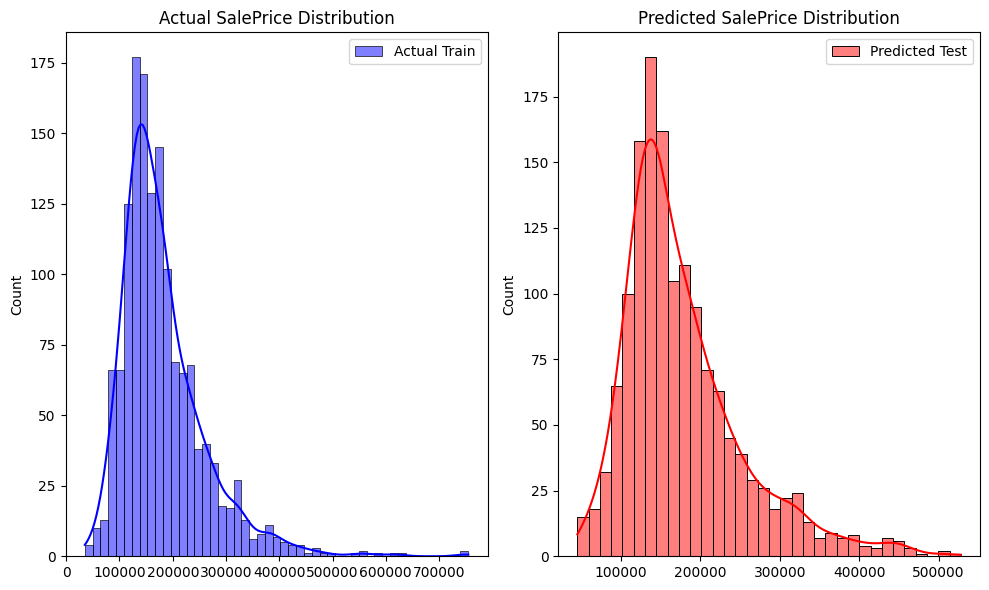

预测价格统计:
最小值: $45,035.52
最大值: $527,880.87
平均值: $177,721.58
中位数: $157,915.40


In [18]:
# 训练最终模型
print("训练最终集成模型...")
averaged_models.fit(X_train, y_train)

# 在训练集上预测（用于检查）
train_predictions = averaged_models.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
print(f"训练集RMSE: {train_rmse:.6f}")

# 在测试集上预测
final_predictions = np.expm1(averaged_models.predict(X_test))

# 生成提交文件
submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': final_predictions
})

# 保存提交文件
submission.to_csv('submission.csv', index=False)
print("提交文件已保存为 'submission.csv'")

# 显示预测分布
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(np.expm1(y_train), kde=True, color='blue', label='Actual Train')
plt.title('Actual SalePrice Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(final_predictions, kde=True, color='red', label='Predicted Test')
plt.title('Predicted SalePrice Distribution')
plt.legend()

plt.tight_layout()
plt.show()

print(f"预测价格统计:")
print(f"最小值: ${final_predictions.min():,.2f}")
print(f"最大值: ${final_predictions.max():,.2f}")
print(f"平均值: ${final_predictions.mean():,.2f}")
print(f"中位数: ${np.median(final_predictions):,.2f}")